The point of this notebook is to implement an Echo state network based on the the paper ["Generating Coherent Patterns of Activity from Chaotic Neural Networks"
](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=d791dde7ddf996fa964587f8a66ba5574e0f897d). Most of the code is based on [this notebook](https://github.com/google-research/computation-thru-dynamics/blob/master/notebooks/FORCE_Learning_in_JAX.ipynb) with some modifications.

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

**On FORCE Learning**:\
Prior to the dominance of gradient based methods, reservior computers (RNNs with fixed internal weights) gained popularity in computational neurosciecne community.The goal of FORCE learning is to adjust the output weights $wO$ of a network so that its output $y(t)$ matches a desired signal $(f(t))$ as closely as possible.

1.   Initialize weights are random and remain unchanged throughout training except for output weights. The critical element that makes this happenn is the **feedback loop** that caries the generated output back into the network.

2. Initialize the inverse correlation matrix $P(0)$, as ${I}/{alpha}$ where this identity matrix has hidden units size and $alpha$ is a small positive constant.

3. At ecach time step t, update the output weights using the RLS algorithm, which minimizes the error between the desired signal $f(t)$ and the actual output $y(t)$.



In [121]:
def random_esn_params(input_size, hidden_size, output_size, tau=1.0, dt=0.1, g=1.0):

  hscale = 0.25
  ifactor = 1.0 / np.sqrt(input_size)
  hfactor = g / np.sqrt(hidden_size)
  pfactor = 1.0 / np.sqrt(hidden_size)
  ffactor = 1.0

    #Weights
  return{'wI' : np.random.randn(hidden_size, input_size) * ifactor,
         'wR' : np.random.randn(hidden_size, hidden_size) * hfactor,
         'wO' : np.random.randn(output_size, hidden_size) * pfactor,
         'wF' : np.random.randn(hidden_size, output_size) * ffactor,
         'a0' : np.random.randn(hidden_size) * hscale,
         'dt_over_tau' : dt/tau}

def new_force_params(hidden_size, alpha=1.0):
  return {'P' : np.eye(hidden_size) * alpha}

def esn(x, a, h, z, wI, wR, wF, wO, dtdivtau):
  """Run the continuous-time Echostate network one step.

    da/dt = -a + wI x + wR h + wF z

    Arguments:
      x: ndarray of input to ESN
      a: ndarray of activations (pre nonlinearity) from prev time step
      h: ndarray of hidden states from prev time step
      z: ndarray of output from prev time step
      wI: ndarray, input matrix, shape (n, u)
      wR: ndarray, recurrent matrix, shape (n, n)
      wF: ndarray, feedback matrix, shape (n, m)
      wO: ndarray, output matrix, shape (m, n)
      dtdivtau: dt / tau

    Returns:
      The update to the ESN at this time step.
  """
  dadt = -a + np.dot(wI, x) + np.dot(wR, h) + np.dot(wF, z)
  a = a + dtdivtau * dadt
  h = np.tanh(a)
  z = np.dot(wO, h)
  return a, h, z

The RLS algorithm updates are based on the following code:

1. Kalman gain vector:$$ k(t) = \frac{P(t - 1)r(t)}{1+r^T(t)P(t - 1)r(t)} $$

  First, we calculate the dot product of Inverse correlation matrix P from the previous time step and hidden state vector at the current time step.
2. Normalization factor (for updating P): $$ c = \frac{1}{1.0+h^tPh}$$

  Then, we compute c, which is a scalar value uesed to normalize the update of the matrix P. It is computed as shown above.
3.Update equation for P:$$ P={P} - \frac{kk^T}{c}$$
The RLS update equation for P is as provided in the equation.
4. Output weight update: $${wO} = {wO} + {k}{(z-f)}^T$$


In [122]:
def rls(h, z, f, wO, P):

  # update inverse correlation matrix
  k = np.expand_dims(np.dot(P, h), axis=1)
  hPh = np.dot(h.T, k) #1
  c = 1.0/(1.0 + hPh) #2
  P = P - np.dot(k*c, k.T) #3

  # update the output weights
  e = np.atleast_2d(z-f)
  dw = np.dot(-c*k, e).T
  return wO + dw, P

In [109]:
def esn_run_and_train(params, fparams, x_t, f_t=None, do_train=False):

  a = params['a0']
  h = np.tanh(a)
  wO = params['wO']
  z = np.dot(wO, h)
  if do_train:
    P = fparams['P']
  else:
    P = None
  h_t = []
  z_t = []

  wI = params['wI']
  wR = params['wR']
  wF = params['wF']
  dtdivtau = params['dt_over_tau']
  for tidx, x in enumerate(x_t):
    a, h, z = esn(x, a, h, z, wI, wR, wF, wO, dtdivtau)
    if do_train:
      wO, P = rls(h, z, f_t[tidx], wO, P)
    h_t.append(h)
    z_t.append(z)

  if do_train:
    fparams['P'] = P
  params['wO'] = wO
  h_t = np.array(h_t)
  z_t = np.array(z_t)
  return params, fparams, h_t, z_t


def esn_run(params, x_t):
  """Run the echostate network forward.

    Arguments:
      params: dict of ESN params
      x_t: ndarray of input with shape (t,u)

    Returns:
      2-tuple of ndarrays with first dim time, the hidden state and the outputs.
  """
  _, _, h_t, z_t  = esn_run_and_train(params, None, x_t,
                                          None, do_train=False)
  return h_t, z_t



def esn_train(params, fparams, x_t, f_t):
  """Run the echostate network forward and also train it.

    Arguments:
      params: dict of ESN params
      fparams: dict of RLS params
      x_t: ndarray of inputs with shape (t,u)
      f_t: ndarray of targets with shape (t,m)

    Returns:
      4-tuple of updated params, fparams, and also ndarrays with first dim
        time, the hidden state and the outputs.
  """
  return esn_run_and_train(params, fparams, x_t, f_t, do_train=True)

In [100]:
T = 30              # total time
input_size = 1               # number of inputs (didn't bother to set up zero, just put in zeros)
hidden_size = 300             # size of the reservoir in the ESN
tau = 1.0           # neuron time constant
dt = tau / 10.0     # Euler integration step
time = np.arange(0, T, dt) # all time
ntime = time.shape[0]      # the number of time steps

x_t = np.zeros((ntime,input_size))
x_t.shape

(300, 1)

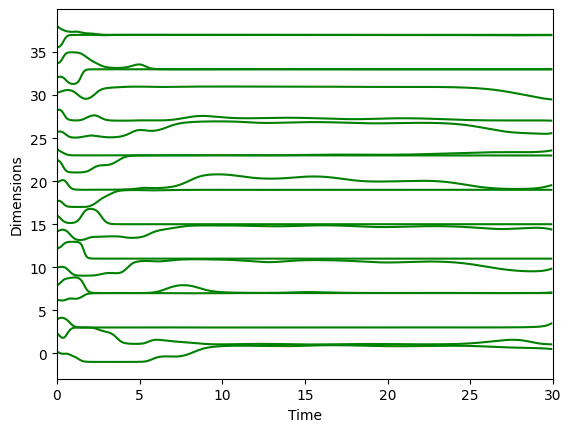

In [110]:
g = 1.8  # Recurrent scaling of the data ESN, gives how wild the dynamics are.
output_size= 20   # Number of targets, and thus outputs for trained ESN.

data_params = random_esn_params(input_size, hidden_size, output_size, g=g)
h_t, z_t = esn_run(data_params, x_t)

f_t = h_t[:,0:output_size] # This will be the training data for the trained ESN
plt.plot(time, f_t + 2*np.arange(0, output_size), 'g');
plt.xlim((0, T))
plt.ylabel('Dimensions')
plt.xlabel('Time');

In [119]:
def print_force(params, fparams, x_t, h_t, z_t, f_t, T):
  """Plot activations and outputs for the Echostate network run."""
  ntoplot = 10
  plt.figure(figsize=(16,16))

  plt.subplot(321)
  plt.plot(time, f_t + 2*np.arange(0, f_t.shape[1]), 'g')
  plt.plot(time, z_t + 2*np.arange(0, z_t.shape[1]), 'r');
  plt.xlim((0, T))
  plt.title('Target - f (green), Output - z (red)')
  plt.xlabel('Time')
  plt.ylabel('Dimension')

  plt.subplot(122)
  plt.imshow(h_t.T, interpolation=None)
  plt.title('Hidden activations of ESN')
  plt.xlabel('Time')
  plt.ylabel('Dimension')

  plt.subplot(323)
  plt.plot(time, h_t[:, 0:ntoplot] + 2*np.arange(0, ntoplot), 'b')
  plt.xlim((0, T))
  plt.title('%d hidden activations of ESN'%(ntoplot))
  plt.xlabel('Time')
  plt.ylabel('Dimension')

  plt.subplot(325)
  plt.plot(time, np.sqrt(np.square(z_t - f_t)), 'c')
  plt.xlim((0, T))
  plt.title('Error - mean absolute error')
  plt.xlabel('Time')
  plt.ylabel('Error')

def plot_params(params):
  """Plot some of the parameters associated with the ESN."""
  plt.figure(figsize=(16,10))
  plt.subplot(221)
  plt.imshow(params['wR'] + np.dot(params['wF'], params['wO']),
            interpolation=None);
  plt.colorbar()
  plt.title('Effective matrix - wR + wF wO')

  plt.subplot(222)
  if params['wO'].shape[0] == 1:
    plt.stem(params['wO'][0,:])
  else:
    plt.imshow(params['wO'], interpolation=None)
    plt.colorbar()
  plt.title('Readout weights - wO');

  x_circ = np.linspace(-1, 1, 1000)
  y_circ = np.sqrt(1-x_circ**2)
  evals, _ = np.linalg.eig(params['wR'])
  plt.subplot(223)
  plt.plot(np.real(evals), np.imag(evals), 'o')
  plt.plot(x_circ, y_circ, 'k')
  plt.plot(x_circ, -y_circ, 'k')
  plt.axis('equal')
  plt.title('Eigenvalues of wR')

  evals, _ = np.linalg.eig(params['wR'] + np.dot(params['wF'], params['wO']))
  plt.subplot(224)
  plt.plot(np.real(evals), np.imag(evals), 'o', color='orange')
  plt.plot(x_circ, y_circ, 'k')
  plt.plot(x_circ, -y_circ, 'k')
  plt.axis('equal');
  plt.title('Eigenvalues of wR + wF wO');

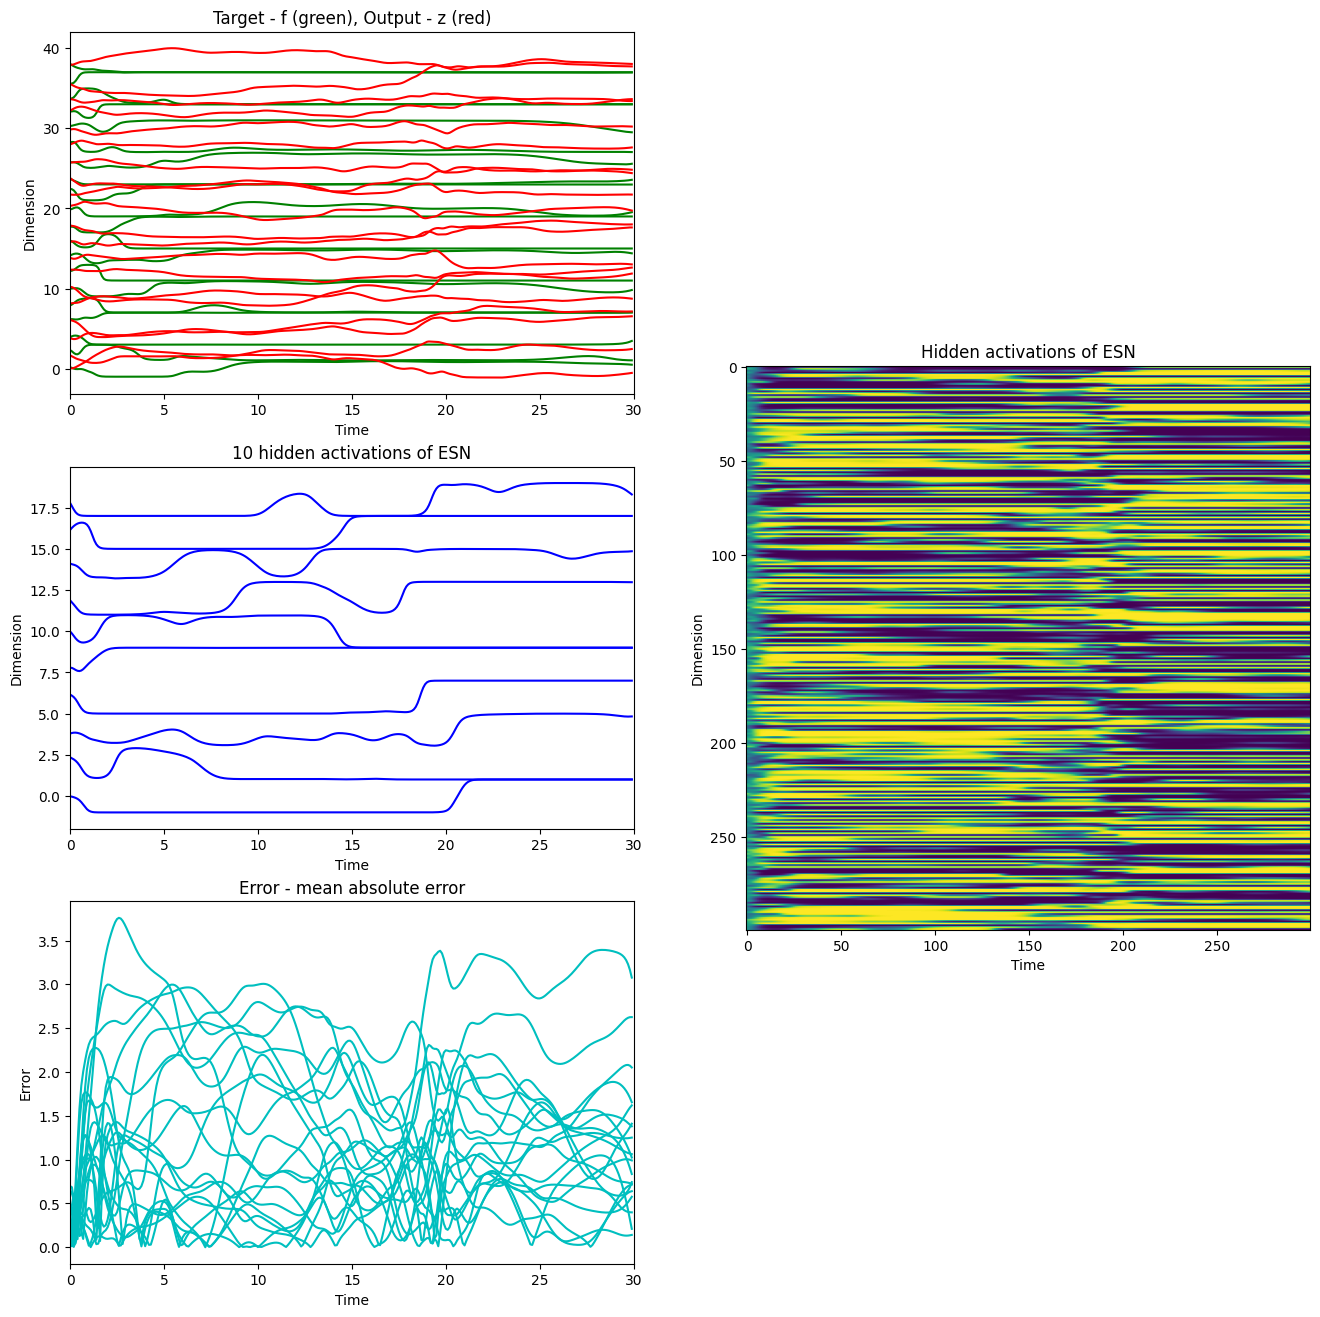

In [111]:
g = 1.5  # Lower g value was shown to be good in the paper for training.
alpha = 1 # Initial learning rate for RLS
init_params = random_esn_params(input_size, hidden_size, output_size, g=g)
fparams = new_force_params(hidden_size, alpha=alpha)

# Run the untrained ESN to get a look it.
h_t, z_t = esn_run(init_params, x_t)
print_force(init_params, fparams, x_t, h_t, z_t, f_t, T)

In [112]:
params = dict.copy(init_params)

In [114]:
ntraining = 15
for train_idx in range(ntraining):
  params, fparams, h_t, z_t = esn_train(params, fparams, x_t, f_t)

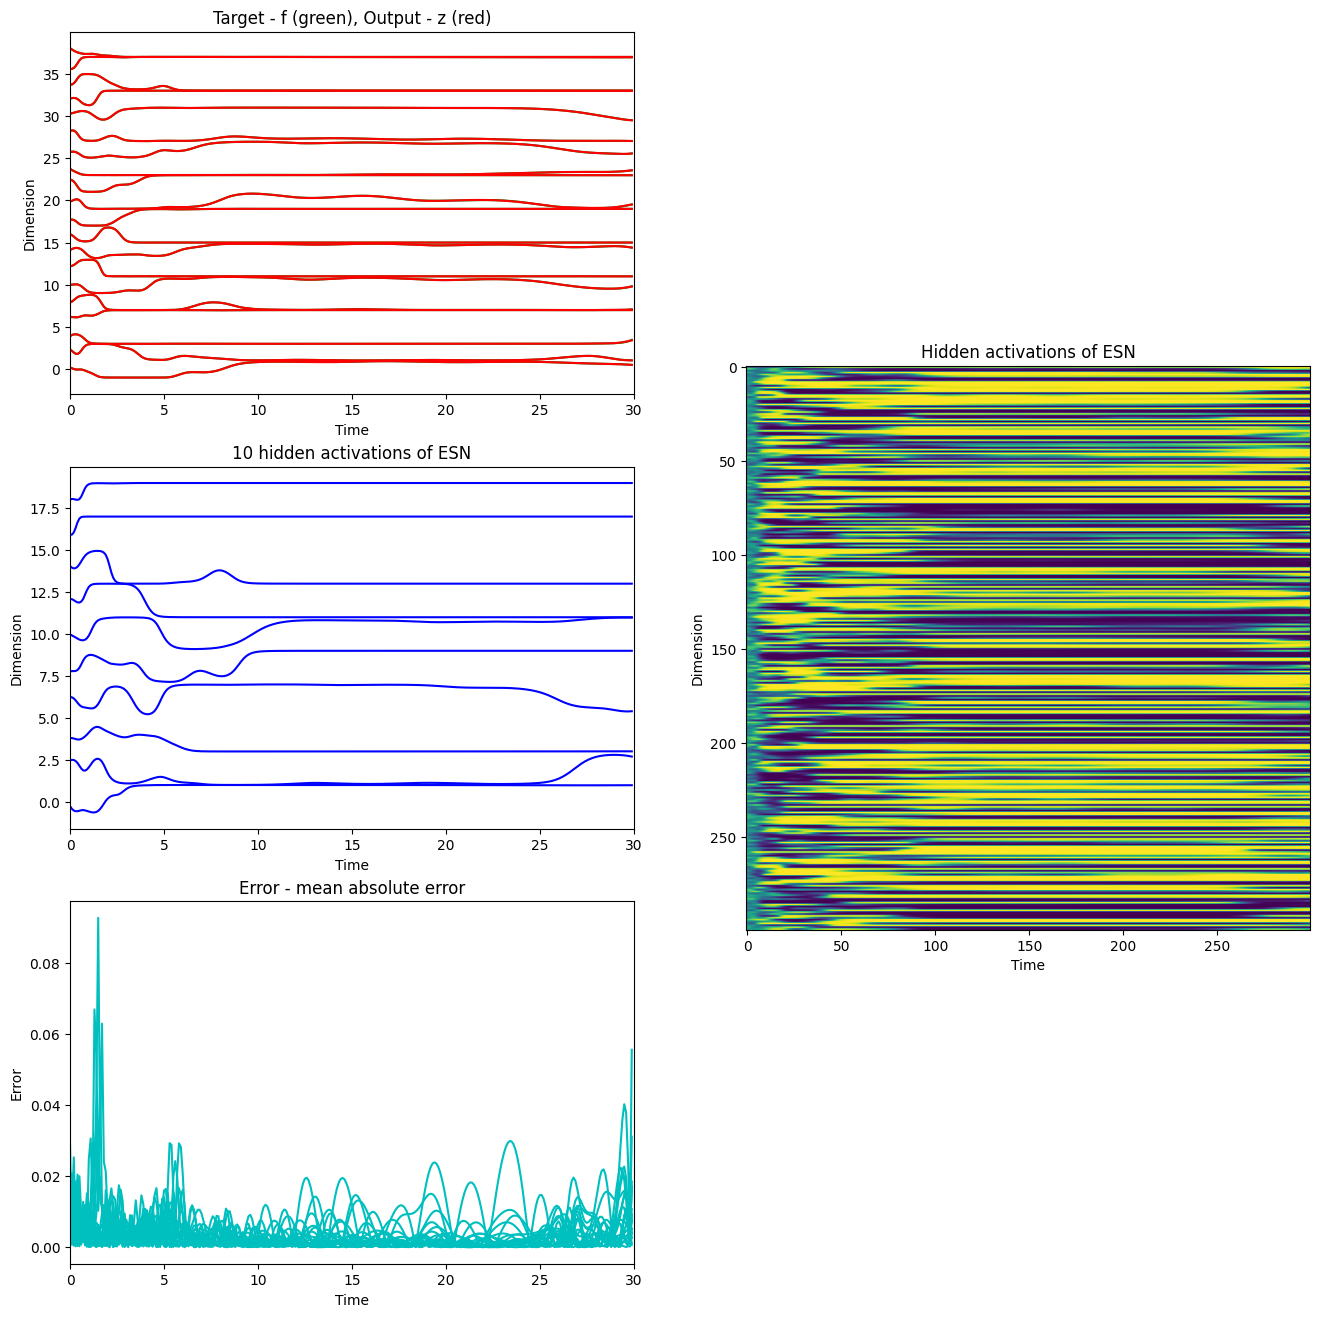

In [115]:
h_t, z_t = esn_run(params, x_t)
print_force(params, fparams, x_t, h_t, z_t, f_t, T)

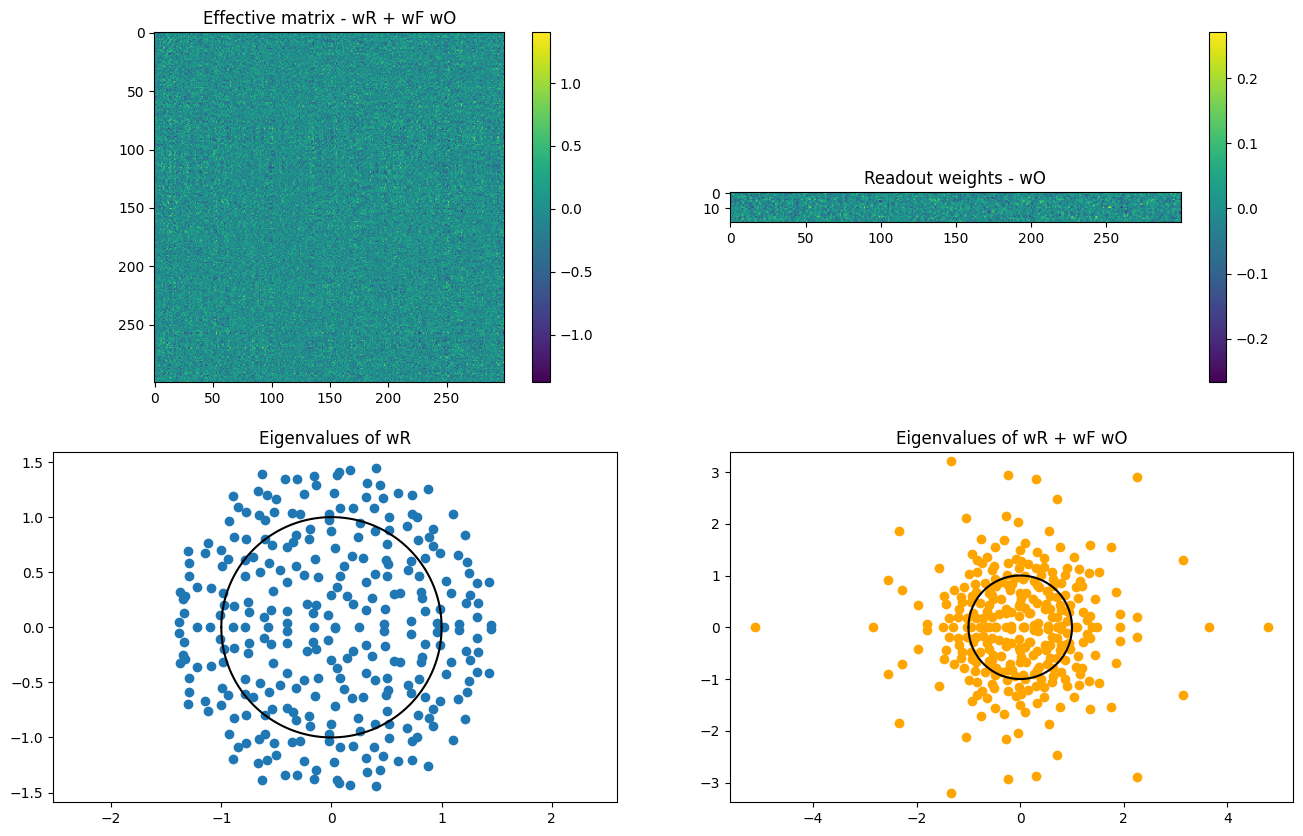

In [120]:
plot_params(params)